# Modelling and Evaluation

## Objectives

*   Business requirement 2: 
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry-leaves_dataset/cherry-leaves/train
* inputs/cherry-leaves_dataset/cherry-leaves/test
* inputs/cherry-leaves_dataset/cherry-leaves/validation
* Image shape embeddings

## Outputs

* Plot distribution of images across train, validation, and test sets.
* Perform image augmentation.
* Map class indices to alter prediction inference for labels.
* Create and train a machine learning model.
* Save the model.
* Plot learning curves to evaluate model performance.
* Evaluate the model using a pickle file.
* Make predictions on a randomly selected image file.

## Additional Comments

* No additional comments here. 

---


# Set The Data Directory & import libraries

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/pp5-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/pp5-mildew-detection-in-cherry-leaves'

## Set input directories

Sets the train, test and validation paths

In [5]:
my_data_dir = 'inputs/cherry-leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
valid_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v4'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('The old version is already available, please create a new version.')
    pass
else:
    os.makedirs(name=file_path)

The old version is already available, please create a new version.


### Set label names

In [7]:
labels = os.listdir(train_path)
print('The label for the images are:', labels)

The label for the images are: ['healthy', 'powdery_mildew']


## Set image shape

Import saved image shape embedding

In [8]:
import joblib

version = 'v3'
img_shape = joblib.load(filename=f"outputs/{version}/img_shape.pkl")
img_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

* train - healthy: 736 images
* train - powdery_mildew: 736 images
* validation - healthy: 105 images
* validation - powdery_mildew: 105 images
* test - healthy: 211 images
* test - powdery_mildew: 211 images




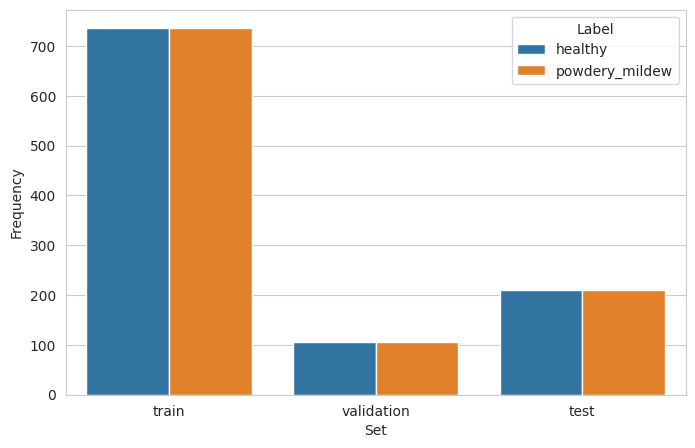

In [9]:
df_img_freq = pd.DataFrame([])

for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_img_freq = df_img_freq.append(
            pd.Series(
                data={
                    'Set': folder,
                    'Label': label,
                    'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
                }
            ),
            ignore_index=True
        )

        print(f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_img_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/label_dist.png', bbox_inches='tight', dpi=150)
plt.show()


---

# Image data augmentation

### Import ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [11]:
augmented_img_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

* ### Augment the train image dataset

In [12]:
batch_size = 1 # was set to 1
train_set = augmented_img_data.flow_from_directory(
    train_path, 
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

train_set.class_indices

Found 1472 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment the validation image dataset

In [13]:
validation_img_data = ImageDataGenerator(rescale=1./255)
validation_set = validation_img_data.flow_from_directory(
    valid_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

validation_set.class_indices

Found 210 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment the test image dataset

In [15]:
test_img_data = ImageDataGenerator(rescale=1./255)
test_set = test_img_data.flow_from_directory(                       
    test_path,
    target_size=img_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_set.class_indices

Found 422 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot the augmented training images

(1, 256, 256, 3)


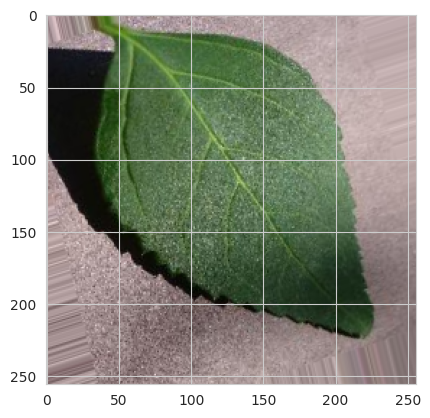

(1, 256, 256, 3)


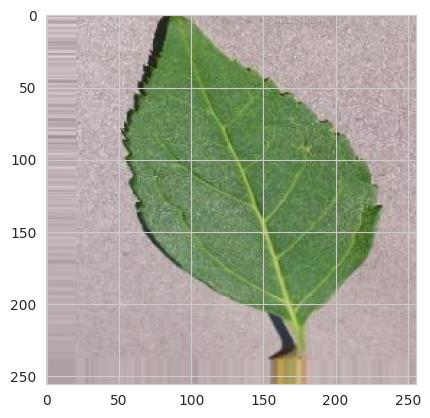

(1, 256, 256, 3)


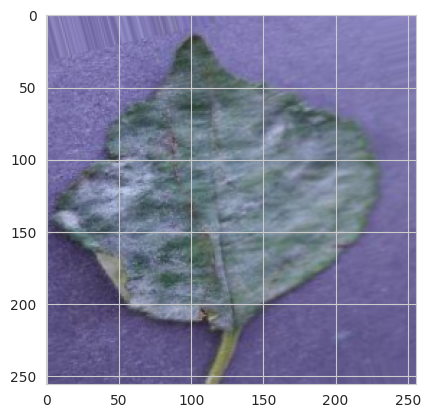

(1, 256, 256, 3)


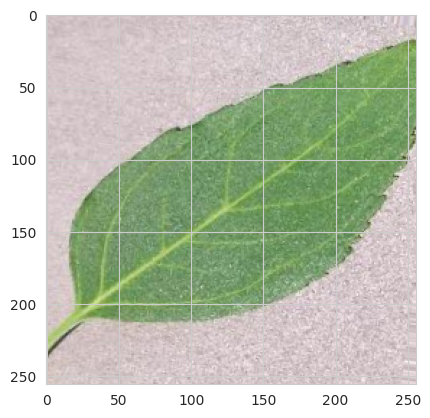

In [16]:
for _ in range(4):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Plot the augmented validation and test images

(1, 256, 256, 3)


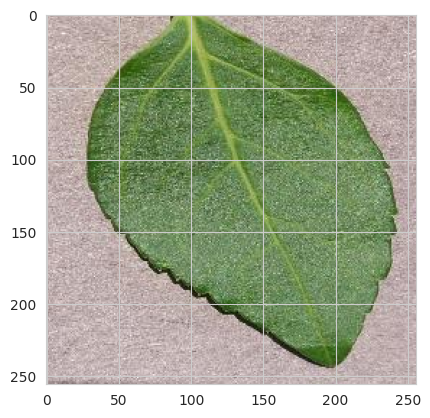

(1, 256, 256, 3)


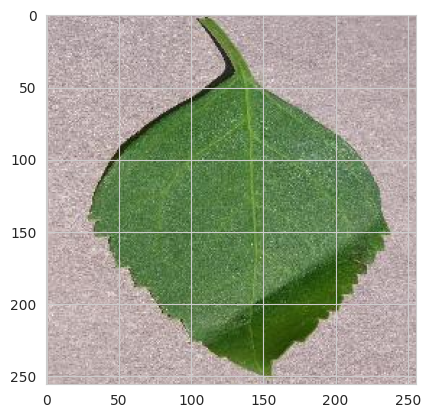

(1, 256, 256, 3)


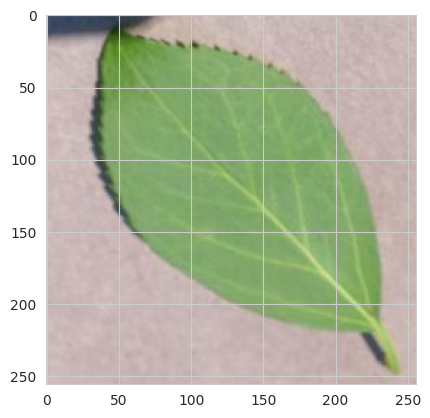

(1, 256, 256, 3)


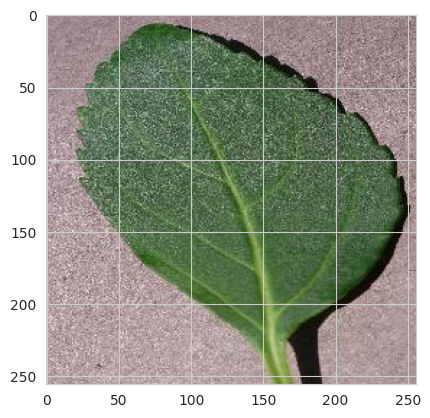

In [17]:
for _ in range(4):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

(1, 256, 256, 3)


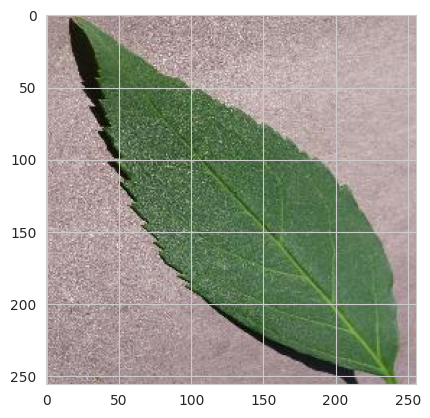

(1, 256, 256, 3)


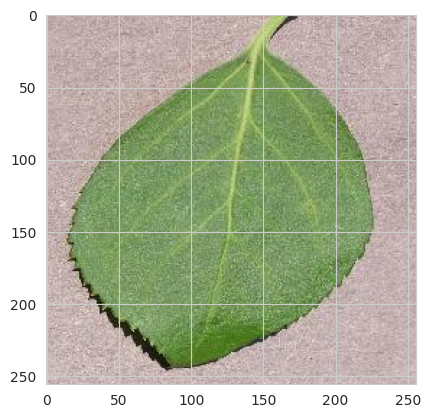

(1, 256, 256, 3)


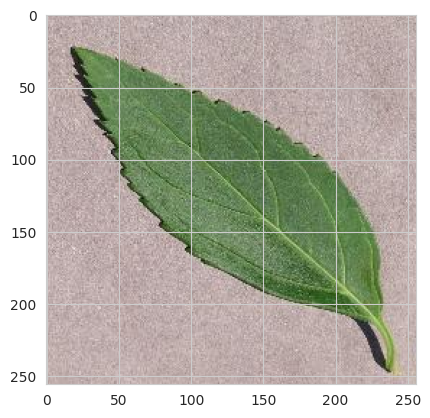

(1, 256, 256, 3)


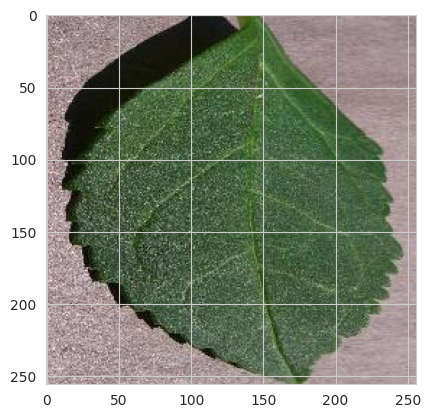

In [18]:
for _ in range(4):
    img, label = test_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

## Save the class_indices

In [19]:
joblib.dump(
    value=train_set.class_indices,
    filename=f"{file_path}/class_indices.pkl"
)

['outputs/v4/class_indices.pkl']

---

# Model creation

## Machine Learning Model

* ### Import model packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [21]:
def generate_tf_model():

    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(filters=16, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3),
              input_shape=img_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Prevent overfitting
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # model.compile(loss='binary_crossentropy',
    #               optimizer='SGD',
    #               metrics=['accuracy'])

    return model

* ### Generate and Model Summary 

In [22]:
model = generate_tf_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

2024-07-24 19:06:46.087161: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Model Early Stopping 

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

train_early_stop = EarlyStopping(monitor='val_loss', patience=4)


## Fit the model for model training

In [24]:
model = generate_tf_model()
history = model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=len(train_set.classes),
    validation_data=validation_set,
    callbacks=[train_early_stop],
    verbose=1
)

2024-07-24 19:06:49.842514: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
1472/1472 [==============================] - 101s 68ms/step - loss: 0.5936 - accuracy: 0.7276 - val_loss: 0.2710 - val_accuracy: 0.8857
Epoch 2/25
1472/1472 [==============================] - 100s 68ms/step - loss: 0.2986 - accuracy: 0.8933 - val_loss: 0.1251 - val_accuracy: 0.9619
Epoch 3/25
1472/1472 [==============================] - 101s 69ms/step - loss: 0.2124 - accuracy: 0.9314 - val_loss: 0.1744 - val_accuracy: 0.9619
Epoch 4/25
1472/1472 [==============================] - 100s 68ms/step - loss: 0.1997 - accuracy: 0.9463 - val_loss: 0.0964 - val_accuracy: 0.9857
Epoch 5/25
1472/1472 [==============================] - 100s 68ms/step - loss: 0.1003 - accuracy: 0.9721 - val_loss: 0.0522 - val_accuracy: 0.9857
Epoch 6/25
1472/1472 [==============================] - 100s 68ms/step - loss: 0.0901 - accuracy: 0.9688 - val_loss: 0.1438 - val_accuracy: 0.9810
Epoch 7/25
1472/1472 [==============================] - 100s 68ms/step - loss: 0.1061 - accuracy: 0.9728 - val_loss: 0

## Save model

In [25]:
model.save('outputs/v4/mildew_detector_model.h5')


# Model Performace

## Model learning curve - 1

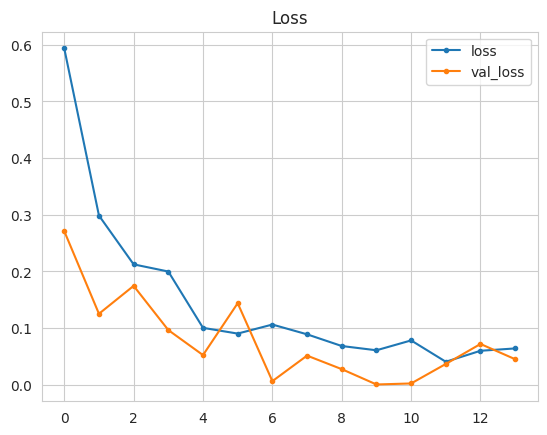

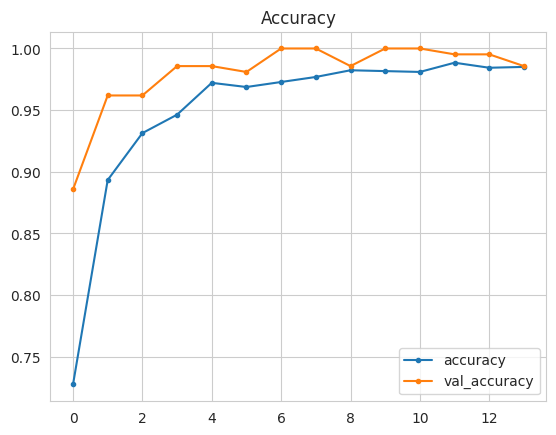

In [26]:
model_training_losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
model_training_losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
model_training_losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_accuracy.png', bbox_inches='tight', dpi=150)
plt.show()

## Model learning curve - 2

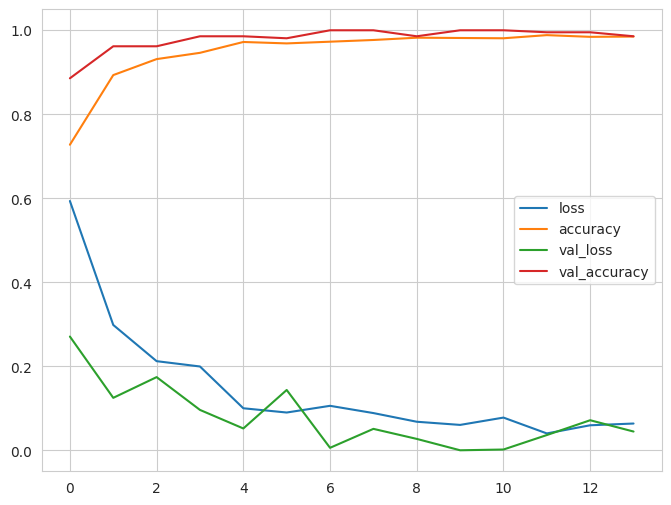

In [27]:
pd.DataFrame(model.history.history).plot(figsize=(8,6))

plt.savefig(f'{file_path}/model_combined.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Import packages

In [28]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from keras.models import load_model

Load the saved model

In [29]:
model = load_model('outputs/v4/mildew_detector_model.h5')

Evaluate the model on the test set

In [30]:
evaluation = model.evaluate(test_set)

422/422 [==============================] - 7s 17ms/step - loss: 0.0422 - accuracy: 0.9834


Confusion Matrix

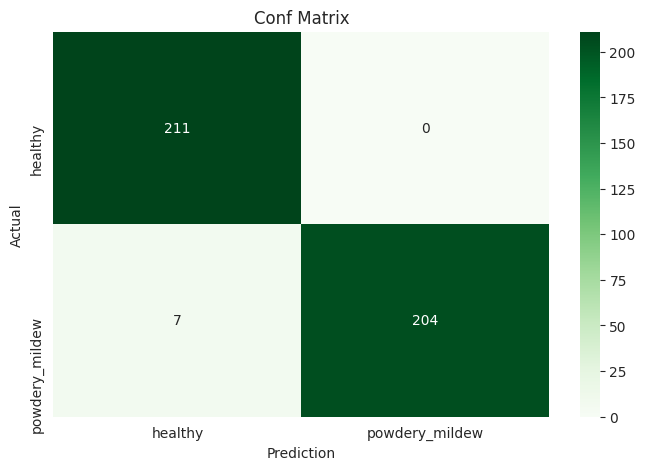

In [31]:
test_set.reset()

# Get true labels and predictions
y_true = test_set.labels
preds = model.predict(test_set)
y_pred = np.rint(preds).astype(int).flatten()

# Compute confusion matrix
con_mat = confusion_matrix(y_true, y_pred)

# Display confusion matrix
classes = list(test_set.class_indices.keys())
plt.figure(figsize=(8, 5))
sns.heatmap(con_mat, annot=True, vmin=0, fmt='g', cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Conf Matrix')
plt.show()
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# import seaborn as sns

# img_shape = (256, 256, 3)

# test_data_dir = 'inputs/cherry-leaves_dataset/cherry-leaves/test'

# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

# test_set = test_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=(256, 256),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False
# )

# y_true = test_set.classes
# preds = model.predict(test_set)
# y_pred = (preds > 0.5).astype(int).flatten()

# # Compute confusion matrix
# con_mat = confusion_matrix(y_true, y_pred)

# # Display confusion matrix
# classes = list(test_set.class_indices.keys())
# plt.figure(figsize=(8, 5))
# sns.heatmap(con_mat, annot=True, vmin=0, fmt='g', cmap="Greens", xticklabels=classes, yticklabels=classes)
# plt.xlabel('Prediction')
# plt.ylabel('Actual')
# plt.title('Conf Matrix')
# plt.show()

In [32]:
print('Classification Report:\n----------------------\n')
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:
----------------------

                precision    recall  f1-score   support

       healthy       0.97      1.00      0.98       211
powdery_mildew       1.00      0.97      0.98       211

      accuracy                           0.98       422
     macro avg       0.98      0.98      0.98       422
  weighted avg       0.98      0.98      0.98       422



Text(0.5, 1.0, 'Classification Report')

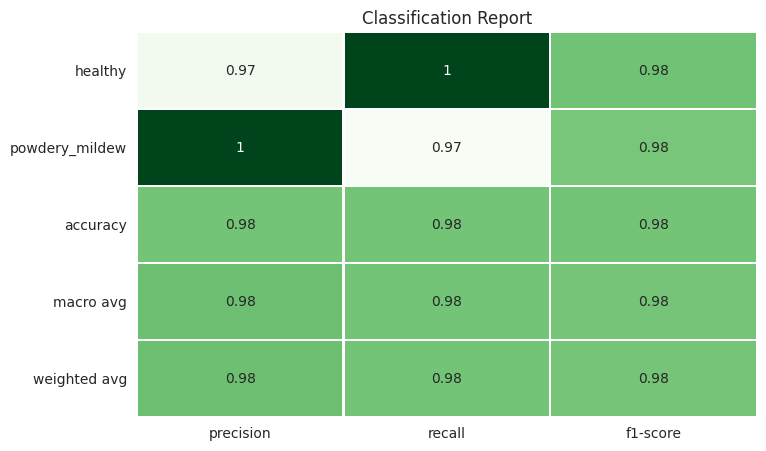

In [35]:
import matplotlib as mpl

clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Greens", cbar=False, linewidths=1)
plt.title('Classification Report')

### Save evaluation

In [36]:
joblib.dump(
    value=evaluation, filename=f"outputs/v4/model_evaluation.pkl"
    )

['outputs/v4/model_evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


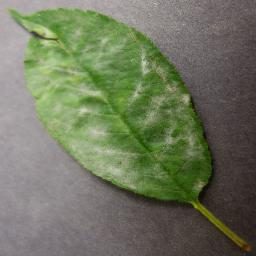

In [37]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # select healthy - 0 or powdery mildew image - 1 

pil_img = image.load_img(
    test_path + '/' + label + '/' + os.listdir(test_path + '/' + label)[pointer],
    target_size=img_shape,
    color_mode='rgb'
)
print(f'Image shape: {pil_img.size}, Image mode: {pil_img.mode}')
pil_img

Convert the image to an array & prepare for prediction

In [38]:
my_img = image.img_to_array(pil_img)
my_img = np.expand_dims(my_img, axis=0)/255
print(my_img.shape)

(1, 256, 256, 3)


Predict the class probabilities

In [40]:
proba_predictions = model.predict(my_img)[0, 0]

target_mapping = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_mapping[proba_predictions > 0.97]

if pred_class == target_mapping[0]:
    proba_predictions = 1 - proba_predictions

print(proba_predictions)
print(pred_class)

0.99999976
powdery_mildew


---

# Push files to Repo

## Push new files from this Session to the GitHub repo

* .gitignore

In [41]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

* Git status

In [42]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/3 - Modelling and Evaluating.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	outputs/v4/

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [ ]:
!git add .

* Git commit

In [ ]:
!git commit -am "Add: New v4"

* Git Push

In [ ]:
!git push

---